In [ ]:
# povezivanje sa Google Drive-a radi uvoza dataseta

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# raspakivanje "traffic-dataset" iz .zip formata

!unzip drive/MyDrive/traffic-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/1479502277713028175.jpg  
  inflating: images/images/1479502278231948873.jpg  
  inflating: images/images/1479502279230178611.jpg  
  inflating: images/images/1479502279730506173.jpg  
  inflating: images/images/1479502280230536426.jpg  
  inflating: images/images/1479502280730839737.jpg  
  inflating: images/images/1479502281729824146.jpg  
  inflating: images/images/1479502282229848985.jpg  
  inflating: images/images/1479502282730102580.jpg  
  inflating: images/images/1479502283731724690.jpg  
  inflating: images/images/1479502284232432719.jpg  
  inflating: images/images/1479502285221790200.jpg  
  inflating: images/images/1479502285730163274.jpg  
  inflating: images/images/1479502286231098378.jpg  
  inflating: images/images/1479502287230097438.jpg  
  inflating: images/images/1479502287730246905.jpg  
  inflating: images/images/1479502288231261057.jpg  
  inflating: images/images/1479502288731301852.j

In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os

In [ ]:
df = pd.read_csv('/content/labels_train.csv')
df

frame  xmin  xmax  ymin  ymax  class_id
0       1478019952686311006.jpg   237   251   143   155         1
1       1478019952686311006.jpg   437   454   120   186         3
2       1478019953180167674.jpg   218   231   146   158         1
3       1478019953689774621.jpg   171   182   141   154         2
4       1478019953689774621.jpg   179   191   144   155         1
...                         ...   ...   ...   ...   ...       ...
132401  1479506176491553178.jpg   166   186   139   156         1
132402  1479506176491553178.jpg   182   204   142   153         1
132403  1479506176491553178.jpg   239   261   139   155         1
132404  1479506176491553178.jpg   259   280   139   157         1
132405  1479506176491553178.jpg   284   324   137   168         1

[132406 rows x 6 columns]

In [ ]:
img_path = '/content/images/images/'
img_list = os.listdir(img_path)
print(f"Ukupan broj slika u datasetu: {len(img_list)}.")

Ukupan broj slika u datasetu: 22241.


In [ ]:
print(f"Broj jedinstvenih slika opisanih .csv fajlom: {len(df.frame.unique())}.")

Broj jedinstvenih slika opisanih .csv fajlom: 18000.


In [ ]:
# provera da li neki od redova sadrzi "null" vrednosti

df.isnull().sum()

frame       0
xmin        0
xmax        0
ymin        0
ymax        0
class_id    0
dtype: int64

In [ ]:
# broj jedinstvenih klasa

df.class_id.unique()

array([1, 3, 2, 5, 4])

In [ ]:
# promena numerisanja klasa od 0-4 umesto originalnih 1-5 zbog kompatibilnosti
# sa koriscenjem YOLOv8 modela

df.class_id = df.class_id - 1
df.head()

frame  xmin  xmax  ymin  ymax  class_id
0  1478019952686311006.jpg   237   251   143   155         0
1  1478019952686311006.jpg   437   454   120   186         2
2  1478019953180167674.jpg   218   231   146   158         0
3  1478019953689774621.jpg   171   182   141   154         1
4  1478019953689774621.jpg   179   191   144   155         0

In [ ]:
labels = { 0:'car', 1:'truck', 2:'person', 3:'bycicle', 4:'traffic_light'}

for k, v in labels.items():
    print(f"Klasa {k} : {v}.", end='\n')

Klasa 0 : car.
Klasa 1 : truck.
Klasa 2 : person.
Klasa 3 : bycicle.
Klasa 4 : traffic_light.


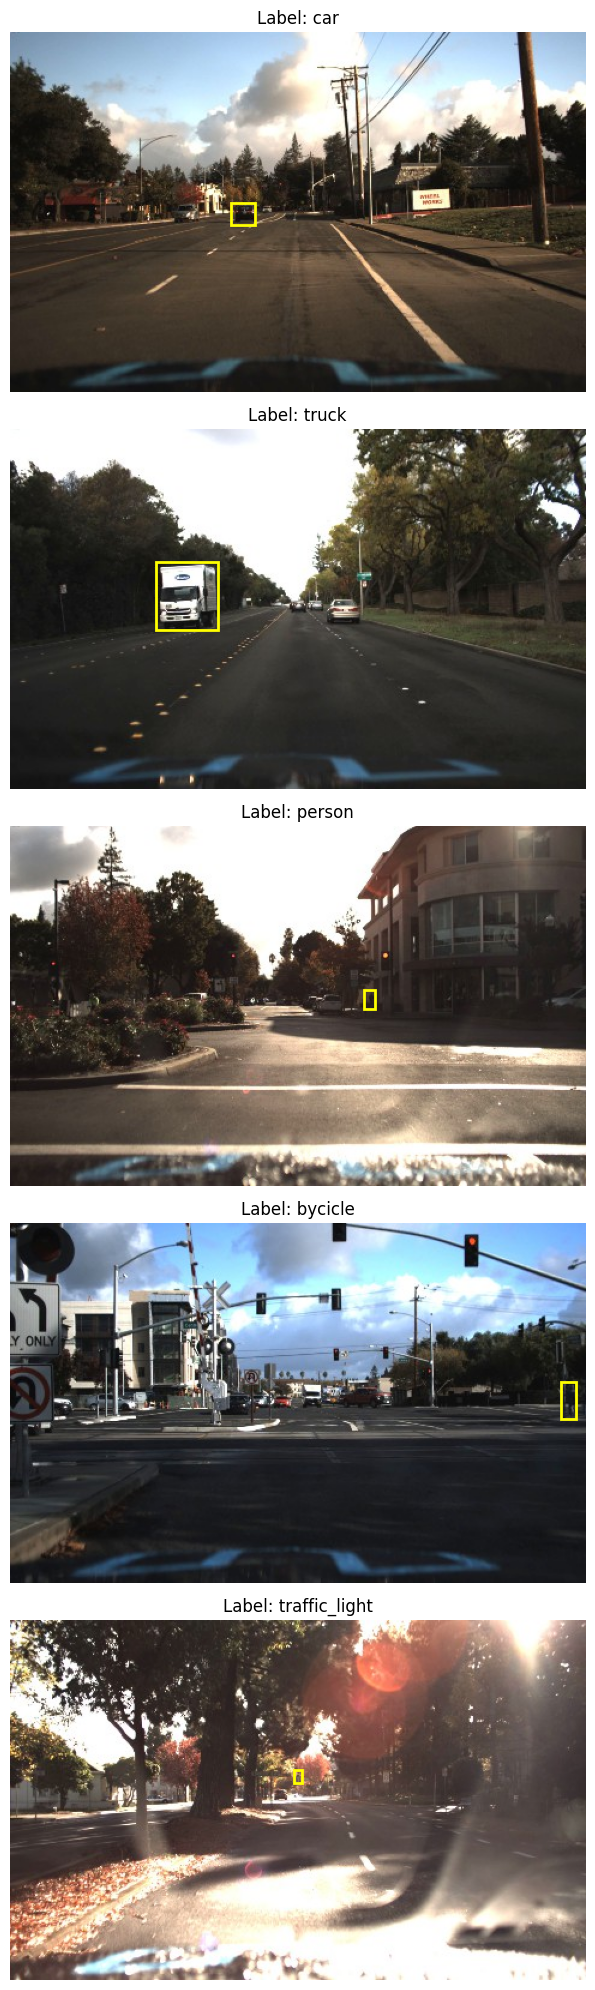

In [ ]:
# Iscrtavanje po jedne slike za svaku klasu sa odgovarajucim bounding-box-om

num_classes = len(labels)

fig, axes = plt.subplots(num_classes, 1, figsize=(8, num_classes * 4))

for i, (class_id, label) in enumerate(labels.items()):
    row = df[df['class_id'] == class_id].iloc[100]

    image = cv2.imread(img_path + row['frame'])

    xmin, xmax, ymin, ymax = row[['xmin', 'xmax', 'ymin', 'ymax']]

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i].imshow(image_rgb)
    axes[i].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    edgecolor='yellow', fill=False, linewidth=2))
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')


plt.tight_layout()
plt.show()

In [ ]:
# putanje do foldera sa slikama i labelama gde ce cuvati YOLO labele
images_folder = '/content/images/images/'
labels_folder = '/content/yolo/labels/'

img_width, img_height = 480, 300

# grupisanje po 'frame' kako bi sve anotacije za istu sliku bile zajedno
grouped = df.groupby('frame')

if not os.path.exists(labels_folder):
    os.makedirs(labels_folder)

# kreiranje YOLO labela za svaku sliku u vidu .txt fajla
for frame, group in grouped:
    label_file = os.path.join(labels_folder, frame.replace('.jpg', '.txt'))

    with open(label_file, 'w') as f:
        for _, row in group.iterrows():
            # provera da li class_id postoji
            if pd.notnull(row['class_id']):
                # normalizaciju koordinata u odnosu na dimenzije slike jer
                # YOLO zahteva centar x, centar y, sirinu i visinu,
                # a nas dataset pruza xmin, xmax, ymin, ymax kao koordinate bbox-a
                class_id = row['class_id']
                x_center = (row['xmin'] + row['xmax']) / 2 / img_width
                y_center = (row['ymin'] + row['ymax']) / 2 / img_height
                width = (row['xmax'] - row['xmin']) / img_width
                height = (row['ymax'] - row['ymin']) / img_height

                yolo_format = f"{class_id} {x_center} {y_center} {width} {height}\n"
                f.write(yolo_format)
            else:
                print(f"Class_id ne postoji za ovaj frame: {frame}")



In [ ]:
# lista svih slika u folderu i dodatna provera da su .jpg fajlovi
image_files = os.listdir(img_path)
image_files = [f for f in image_files if f.endswith('.jpg')]

# slike sa objektima iz originalnog .csv fajla
images_with_objects = df['frame'].unique()

# slike bez objekata kao lista
images_without_objects = list(set(image_files) - set(images_with_objects))

# broj slika sa i bez objekata
print(f"Slike sa objektima: {len(images_with_objects)}")
print(f"Slike bez objekata: {len(images_without_objects)}")


Slike sa objektima: 18000
Slike bez objekata: 4241


In [ ]:
from sklearn.model_selection import train_test_split

# podela slika sa objektima na 80%-20%
train_images_with_objects, test_images_with_objects = train_test_split(images_with_objects, test_size=0.2, random_state=42)

# podela slika bez objekata na 80%-20%
train_images_without_objects, test_images_without_objects = train_test_split(images_without_objects, test_size=0.2, random_state=42)

# kombinovanje lista radi jednake procentualne raspodele u trening i validacionom setu
train_images = list(train_images_with_objects) + list(train_images_without_objects)
test_images = list(test_images_with_objects) + list(test_images_without_objects)

print(f"Trening set: {len(train_images)} slika")
print(f"Test set: {len(test_images)} slika")

Trening set: 17792 slika
Test set: 4449 slika


In [ ]:
# kreiranje strukture direktorijuma kakvu zahteva YOLOv8
os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/images/val', exist_ok=True)
os.makedirs('dataset/labels/train', exist_ok=True)
os.makedirs('dataset/labels/val', exist_ok=True)

In [ ]:
import shutil

source_img_dir = '/content/images/images/'
source_label_dir = 'yolo/labels/'
train_img_dir = 'dataset/images/train/'
val_img_dir = 'dataset/images/val/'
train_label_dir = 'dataset/labels/train/'
val_label_dir = 'dataset/labels/val/'

# funkcija za premestanje slika i labela u odgovarajuce foldere
def move_images_and_labels(image_list, img_dest_dir, label_dest_dir):
    for image in image_list:
        img_source_path = os.path.join(source_img_dir, image)

        image_name_without_ext = os.path.splitext(image)[0]

        label_file = f"{image_name_without_ext}.txt"
        label_source_path = os.path.join(source_label_dir, label_file)

        if os.path.exists(img_source_path):
            shutil.copy(img_source_path, img_dest_dir)

        if os.path.exists(label_source_path):
            shutil.copy(label_source_path, label_dest_dir)
        else:
            empty_label_path = os.path.join(label_dest_dir, label_file)
            with open(empty_label_path, 'w') as f:
                pass

move_images_and_labels(train_images, train_img_dir, train_label_dir)

move_images_and_labels(test_images, val_img_dir, val_label_dir)

In [ ]:
# provera da li train i val folderi sadrze isti broj fajlova

train_images_path = '/content/dataset/images/train'
val_images_path = '/content/dataset/images/val'
train_labels_path = '/content/dataset/labels/train'
val_labels_path = '/content/dataset/labels/val'

def count_files_in_directory(directory):
    return len(os.listdir(directory))

train_images_count = count_files_in_directory(train_images_path)
val_images_count = count_files_in_directory(val_images_path)
train_labels_count = count_files_in_directory(train_labels_path)
val_labels_count = count_files_in_directory(val_labels_path)

print(f"Broj slika u trening folderu: {train_images_count}.")
print(f"Broj slika u validacionom folderu: {val_images_count}.")
print(f"Broj labela u trening folderu: {train_labels_count}.")
print(f"Broj labela u validacionom folderu: {val_labels_count}.")


Broj slika u trening folderu: 17792.
Broj slika u validacionom folderu: 4449.
Broj labela u trening folderu: 17792.
Broj labela u validacionom folderu: 4449.


In [ ]:
# ugradjena shell komanda !pip install za preuzimanje biblioteke
# koja pruza mogucnost koriscenja YOLOv8 modela

!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 14.7 MB/s eta 0:00:00


In [ ]:
# kreiranje .yaml datoteke

yaml_content = """
train: dataset/images/train
val: dataset/images/val

nc: 5
names: ['car', 'truck', 'person', 'bicycle', 'traffic_light']
"""

with open('data.yaml', 'w') as f:
    f.write(yaml_content)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 182MB/s]


In [ ]:
# fine-tuning YOLOv8m (medium) modela

results = model.train(data='/content/data.yaml', epochs=10, batch=16, imgsz=480)

Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 14.8MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 77.0MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/labels/train... 17792 images, 3392 backgrounds, 0 corrupt: 100%|██████████| 17792/17792 [00:11<00:00, 1613.68it/s]

train: WARNING ⚠️ /content/dataset/images/train/1478020644712955174.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/images/train/1478021875081281646.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/images/train/1478731898295473636.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/images/train/1478731920661488084.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/images/train/1478731922955810314.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/images/train/1478732493572404397.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/images/train/1478732688555973177.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/images/train/1478897760163798179.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/images/train/1478898000105422598.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/dataset/images/train/1478898021242957332.jpg: 1 duplicate labels removed


train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/labels/val... 4449 images, 849 backgrounds, 0 corrupt: 100%|██████████| 4449/4449 [00:03<00:00, 1455.48it/s]

val: WARNING ⚠️ /content/dataset/images/val/1478020832210646675.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/dataset/images/val/1478020944220115330.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/dataset/images/val/1478732457442720557.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/dataset/images/val/1478732887556135464.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/dataset/images/val/1478898145212453716.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/dataset/images/val/1479502405738686444.jpg: 1 duplicate labels removed


val: New cache created: /content/dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.15G      1.464       1.16      1.094         84        480: 100%|██████████| 1112/1112 [07:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:38<00:00,  3.63it/s]


                   all       4449      26399       0.58      0.391      0.408        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.09G      1.471     0.9897      1.104         70        480: 100%|██████████| 1112/1112 [06:47<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:36<00:00,  3.84it/s]


                   all       4449      26399      0.588       0.45      0.465      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.15G      1.441     0.9391      1.089        101        480: 100%|██████████| 1112/1112 [06:40<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:36<00:00,  3.87it/s]


                   all       4449      26399      0.596      0.475      0.485      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.15G      1.402     0.8746      1.073        110        480: 100%|██████████| 1112/1112 [06:36<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:36<00:00,  3.83it/s]


                   all       4449      26399      0.639      0.486      0.523      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.14G      1.362     0.8237      1.053         87        480: 100%|██████████| 1112/1112 [06:40<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:36<00:00,  3.85it/s]


                   all       4449      26399      0.677      0.513      0.559      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.14G       1.33     0.7806      1.041         95        480: 100%|██████████| 1112/1112 [06:44<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:36<00:00,  3.84it/s]


                   all       4449      26399      0.701      0.529      0.575      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.15G      1.304     0.7484      1.029        108        480: 100%|██████████| 1112/1112 [06:40<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:36<00:00,  3.87it/s]


                   all       4449      26399      0.691      0.565      0.603      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.13G      1.275     0.7094      1.017         96        480: 100%|██████████| 1112/1112 [06:39<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:35<00:00,  3.97it/s]


                   all       4449      26399      0.734      0.561      0.617       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.14G      1.252     0.6771      1.008        113        480: 100%|██████████| 1112/1112 [06:34<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:34<00:00,  4.00it/s]


                   all       4449      26399      0.756      0.564       0.64      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.13G      1.227     0.6487     0.9967         91        480: 100%|██████████| 1112/1112 [06:33<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:36<00:00,  3.87it/s]


                   all       4449      26399       0.76       0.59      0.655      0.369

10 epochs completed in 1.233 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 140/140 [00:41<00:00,  3.34it/s]


                   all       4449      26399       0.76       0.59      0.655      0.369
                   car       3544      20317      0.859      0.769      0.845      0.543
                 truck        904       1266      0.803      0.651      0.728      0.497
                person        796       2002      0.729      0.434      0.518      0.243
               bicycle        167        254       0.54      0.461      0.461      0.219
         traffic_light        651       2560       0.87      0.636      0.721      0.341
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


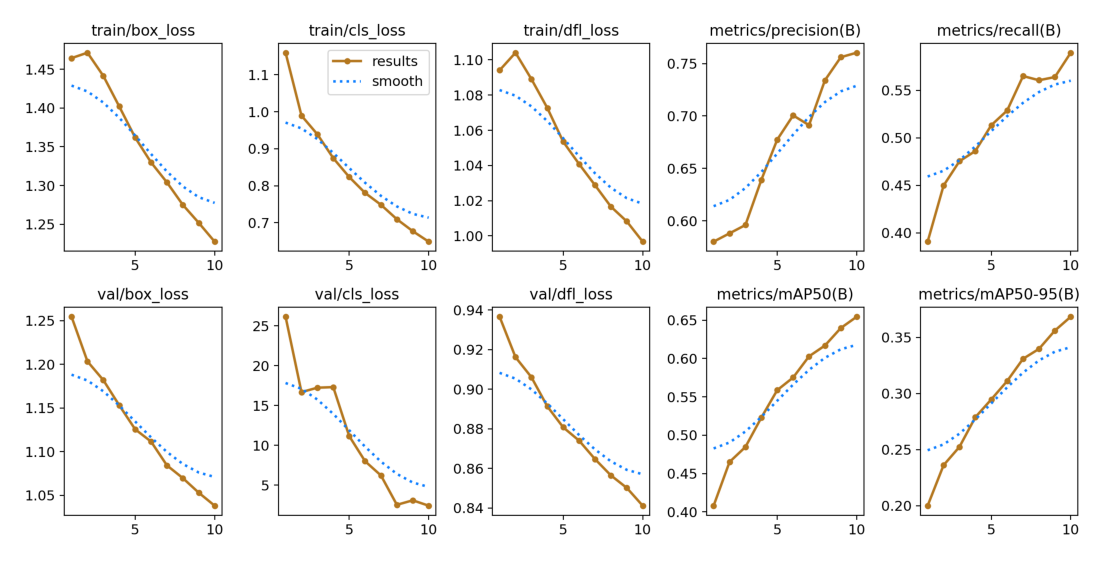

In [ ]:
# prikaz metrika

result_img_path = '/content/runs/detect/train/results.png'

res_image = cv2.imread(result_img_path)

plt.figure(figsize=(14, 10))
plt.imshow(res_image)
plt.axis('off')
plt.show()

In [ ]:
import random

# prikaz predikcije modela na 5 nasumicno izabranih slika iz validacionog skupa
eval_model = YOLO('/content/runs/detect/train/weights/best.pt')

val_images_path = 'dataset/images/val/'

all_images = [f for f in os.listdir(val_images_path) if f.endswith(('.jpg'))]

sample_images = random.sample(all_images, 5)

sample_image_paths = [os.path.join(val_images_path, img) for img in sample_images]

eval_results = model.predict(source=sample_image_paths, show=True, save=True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


0: 416x640 8 cars, 7 traffic lights, 50.8ms
1: 416x640 4 cars, 1 truck, 50.8ms
2: 416x640 1 person, 2 cars, 1 truck, 50.8ms
3: 416x640 3 persons, 1 bicycle, 5 cars, 50.8ms
4: 416x640 9 cars, 1 truck, 3 traffic lights, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 232.8ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict


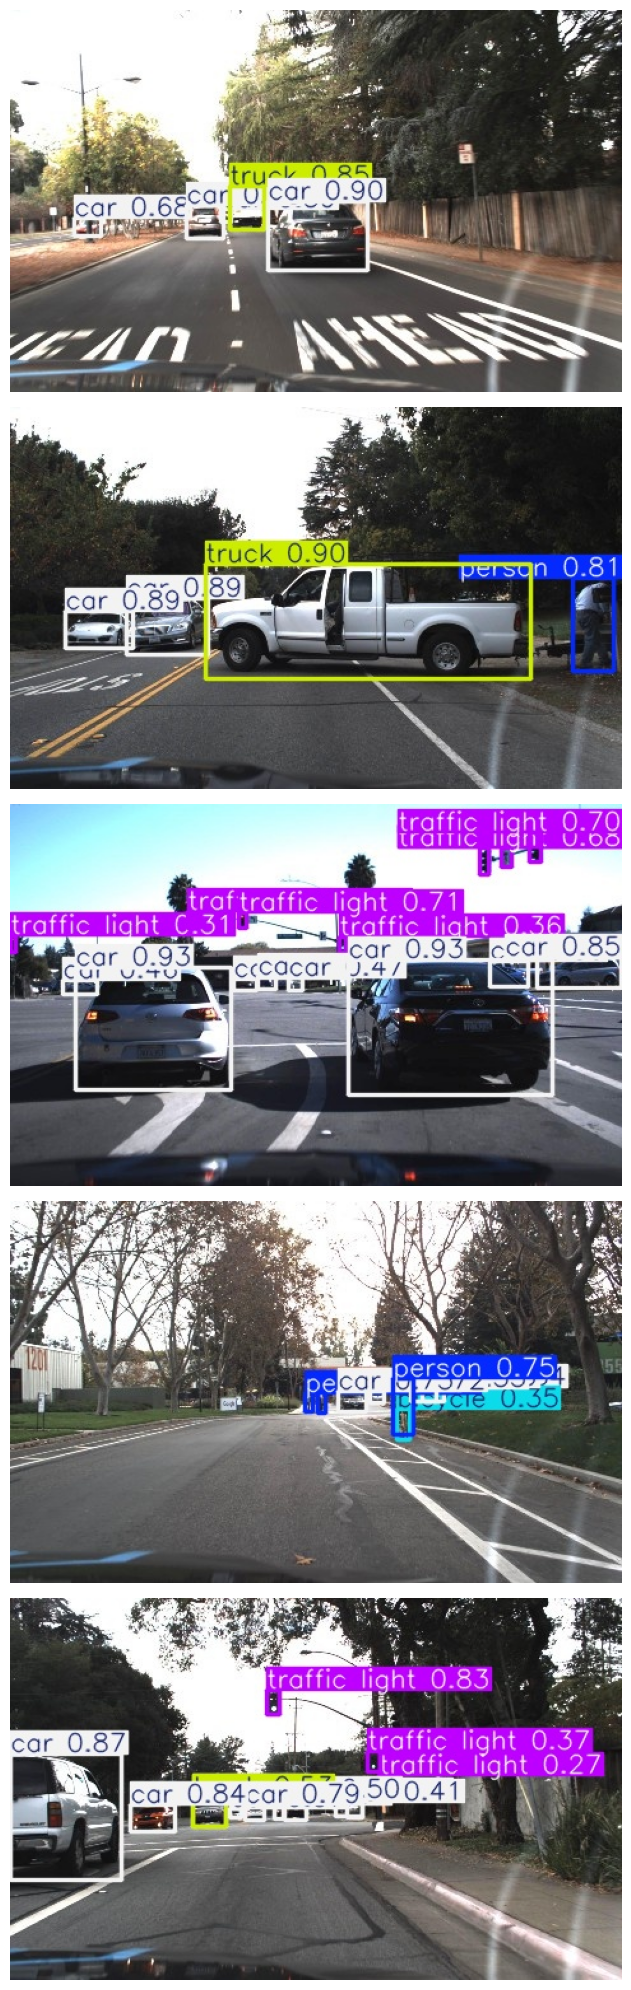

In [ ]:
predicted_images_path = '/content/runs/detect/predict'

predicted_images_list = [f for f in os.listdir(predicted_images_path) if f.endswith('.jpg')]

predicted_images = predicted_images_list[:5]

fig, axes = plt.subplots(len(predicted_images), 1, figsize=(20, len(predicted_images) * 4))

for ax, img_name in zip(axes, predicted_images):
    img_path = os.path.join(predicted_images_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()